In [18]:
# This notebook read the resnet50 descriptors (in CHECKPOINT_DIR) generated 
# by MakeDescriptors to be analysed
import os
import PIL
import cv2
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from collections import OrderedDict
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from scipy import sparse
from astropy.io import fits

%matplotlib inline

In [19]:
# Paths
PROJECT_DIR = "/data/notebooks/uves_jprieto/Tutorial"
# Model checkpoints
CHECKPOINT_DIR = os.path.join(PROJECT_DIR, "checkpoint")

In [20]:
# Number of processed images
n_files = 10
# List of fits images to process
# * bias_red:
#   - UVES_RED_BIAS (ext: 1,2)
# * bias_blue:
#   - UVES_BLUE_BIAS (ext: 0)
# * blue_arc_flat:
#   - UVES_BLUE_WAVE (ext: 1,2)
#   - UVES_DIC1B_FLAT (ext: 0)
#   - UVES_DIC1B_DFLAT (ext: 0)
# * red_arc_flat:
#   - UVES_RED_WAVE (ext: 1,2)
#   - UVES_DIC1R_FLAT (ext: 1,2)
fits_folder = 'UVES_RED_BIAS'
ext = 1
fits_data_dir = '../data/fits_for_test'
fits_data_dir = os.path.join(fits_data_dir,fits_folder)
fits_files = [os.path.join(fits_data_dir,s) for s in os.listdir(fits_data_dir)]
# Number of images to process
n_files = 10
#n_files = len(fits_files)
print('Folder '+ fits_folder +' contains '+ str(len(fits_files)) + ' .fits files.')
print('Selecting ' + str(n_files) + ' files.')

# Dor random selection
#IMG_DIRECTORY_LIST = random.sample(fits_files, n_files)
#IMG_DIRECTORY_LIST[0:n_files]

IMG_DIRECTORY_LIST = fits_files[0:n_files]
IMG_DIRECTORY_LIST

Folder UVES_RED_BIAS contains 97 .fits files.
Selecting 10 files.


['../data/fits_for_test/UVES_RED_BIAS/UVES_RED_BIAS050_0005.fits',
 '../data/fits_for_test/UVES_RED_BIAS/UVES_RED_BIAS245_0001.fits',
 '../data/fits_for_test/UVES_RED_BIAS/UVES_RED_BIAS285_0001.fits',
 '../data/fits_for_test/UVES_RED_BIAS/UVES_RED_BIAS202_0002.fits',
 '../data/fits_for_test/UVES_RED_BIAS/UVES_RED_BIAS275_0001.fits',
 '../data/fits_for_test/UVES_RED_BIAS/UVES_RED_BIAS147_0004.fits',
 '../data/fits_for_test/UVES_RED_BIAS/UVES_RED_BIAS243_0005.fits',
 '../data/fits_for_test/UVES_RED_BIAS/UVES_RED_BIAS087_0003.fits',
 '../data/fits_for_test/UVES_RED_BIAS/UVES_RED_BIAS248_0002.fits',
 '../data/fits_for_test/UVES_RED_BIAS/UVES_RED_BIAS235_0004.fits']

In [21]:
descriptor_file = os.path.join(CHECKPOINT_DIR,'full_unflat_desc_'+str(fits_folder)+'_ext'+str(ext)+'_resNet50_N'+str(n_files)+'.npy')
descs_resNet50 = np.load(descriptor_file)
np_descs = np.array(descs_resNet50)
np_descs.shape

(10, 2048)

In [22]:
def flatten_descs(descs, IMG_DIRECTORY_LIST):
    np_descs = descs
    flat_descs = []
    names = []
    for row_idx in range(np_descs.shape[0]):
        row = np_descs[row_idx]
        n_row = row.flatten()
        flat_descs.append(n_row)
        names.append(IMG_DIRECTORY_LIST[row_idx])
        
    return np.array(flat_descs), np.array(names)

In [23]:
# For performance, we sparsify matrix
flat_descs, names = flatten_descs(descs_resNet50, IMG_DIRECTORY_LIST)  # (n_imgs, (4032, img_name))

corrupted_idx=np.where(np.isnan(np.sum(flat_descs, axis=1)))
print("Corrupted images index: ", corrupted_idx)
for idx in corrupted_idx:
    flat_descs[idx,:]=0.

d_sparse = sparse.csr_matrix(flat_descs)

Corrupted images index:  (array([], dtype=int64),)


In [25]:
print('Flat descriptors shape: ',flat_descs.shape)

Flat descriptors shape:  (10, 2048)


In [26]:
# In order to study the "distance" between different vectors in a given set it is usefuel to creat a similarity 
# matrix with a given metric relating vector "i" with vector "j". In this case we show an example for 
# the cosine-similarity matrix, which shows the cosine of the angle between vectors in the hyper-space
# In this case the vectors are the 2048-dimension descriptors from the resnet50

# Compute all-vs-all cosine similarity (should be query-vs-all at test-time, extra param in c_s(X, Y))
batch_size=2000
if True:
    with tqdm(total=d_sparse.shape[0]) as pbar:
        # All descriptors do not fit at once. We compute and save in segments
        for i in range(0, d_sparse.shape[0], 2000):
            try:
                sims = cosine_similarity(d_sparse, d_sparse[i:i+2000])
            except:
                sims = cosine_similarity(d_sparse, d_sparse[i:])
            np.save(os.path.join(CHECKPOINT_DIR, 'similarities_part_{}'.format(i//2000)), sims)
            pbar.update(2000)

2000it [00:00, 514007.84it/s]         


In [27]:
# Integrate similarity segments in one big tensor, on memory, from saved np files
all_sims = None  # shape (n_imgs, n_imgs)
for i in range(0, d_sparse.shape[0], batch_size):
    try:
        all_sims[0]
        all_sims = np.hstack((all_sims, np.load(os.path.join(CHECKPOINT_DIR, 'similarities_part_{}.npy'.format(i//batch_size)))))
    except:
        all_sims = np.load(os.path.join(CHECKPOINT_DIR, 'similarities_part_{}.npy'.format(i//batch_size)))

In [28]:
# Save the first time
if True:
    np.save(os.path.join(CHECKPOINT_DIR, 'full_descriptors_'+str(fits_folder)+'_ext'+str(ext)+'_resNet50_N'+str(n_files)), flat_descs)
    np.save(os.path.join(CHECKPOINT_DIR, 'paths'), names)

In [32]:
similarities= all_sims

#np.fill_diagonal(similarities, np.nan)
#np.fill_diagonal(similarities, 1.0)
for idx in corrupted_idx:
    similarities[idx,:]=np.nan
    similarities[:,idx]=np.nan

print("Shape:\t\t\t{}".format(similarities.shape))
print('Mean distance:\t\t{}'.format(np.nanmean(similarities)))
print('Distance StD:\t\t{}'.format(np.nanstd(similarities)))
print('\nPairwise dense output:\n\n{}\n'.format(similarities))

Shape:			(10, 10)
Mean distance:		0.9431181047664411
Mean distance:		0.058584758982620604

Pairwise dense output:

[[1.         0.96801529 0.88319068 0.94648037 0.99566684 0.982892
  0.99321933 0.90491933 0.91950083 0.99810949]
 [0.96801529 1.         0.78605302 0.86149322 0.94980486 0.99524144
  0.93889303 0.80992773 0.82668632 0.96777027]
 [0.88319068 0.78605302 1.         0.98225021 0.90399851 0.81592467
  0.91913921 0.99737387 0.99399721 0.88221453]
 [0.94648037 0.86149322 0.98225021 1.         0.96250105 0.88996673
  0.97250054 0.99111923 0.99605546 0.94610261]
 [0.99566684 0.94980486 0.90399851 0.96250105 1.         0.97116722
  0.9980637  0.92434351 0.93833591 0.99741517]
 [0.982892   0.99524144 0.81592467 0.88996673 0.97116722 1.
  0.96101901 0.83986191 0.85671732 0.98472135]
 [0.99321933 0.93889303 0.91913921 0.97250054 0.9980637  0.96101901
  1.         0.93859684 0.95078786 0.99285415]
 [0.90491933 0.80992773 0.99737387 0.99111923 0.92434351 0.83986191
  0.93859684 1.       

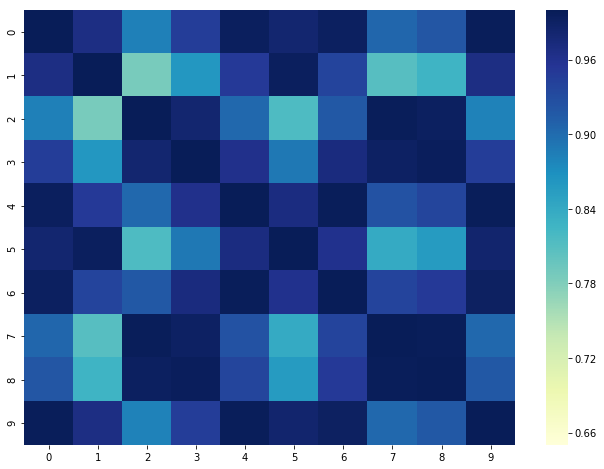

In [37]:
mean_sim = np.nanmean(similarities)
std_sim = np.nanstd(similarities)
fig, ax = plt.subplots(figsize=(11,8))
sns.heatmap(similarities, cmap="YlGnBu", vmin=mean_sim-5.0*std_sim, vmax=1.0)